In [62]:
project_id = 'pytorch-tpu-nfs'
dataset_id = 'view_dataset'
table_id = 'weather_time_series'
experiment_id = 'weather-exp'
staging_bucket = 'gs://automl-samples'
location='us-central1'
context_window = 24

In [63]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

import tempfile
import argparse
import sys
import os

from view_demo.utils import get_project_id
csv_path = 'gs://bench-datasets/jena_climate_2009_2016.csv'
df = pd.read_csv(csv_path)

# Convert to hourly dataset
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

# Clean Data
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()


# Rename Columns to comply with BQ
df.rename(columns={
    'p (mbar)': 'p__mbar',
    'T (degC)': 'T__degC',
    'Tpot (K)': 'Tpot__K',
    'Tdew (degC)': 'Tdew__degC',
    'rh (%)': 'rh__percent',
    'VPmax (mbar)': 'VPmax__mbar' ,
    'VPact (mbar)': 'VPact__mbar',
    'VPdef (mbar)': 'VPdef__mbar',
    'sh (g/kg)': 'sh__g_per_kg',
    'H2OC (mmol/mol)': 'H2OC__mmol_per_mol',
    'rho (g/m**3)': 'rho__gm_per_cubic_m',
    'max Wx': 'max_Wx',
    'max Wy': 'max_Wy',
    'Day sin': 'Day_sin',
    'Day cos': 'Day_cos',
    'Year sin': 'Year_sin',
    'Year cos': 'Year_cos',
    'Date Time': 'Date_Time',
    'wv (m/s)' : 'wv__m_per_s',
    'max. wv (m/s)': 'max_w__vm_per_s',
    'wd (deg)': 'wd__deg'

}, inplace=True)

# Write to BQ
client = bigquery.Client(location="us-central1", project=project_id)
print("Client creating using default project: {}".format(client.project))

try:
    dataset = client.get_dataset(dataset_id)  # Make an API request.
    print("Dataset {} already exists".format(dataset_id))
except NotFound:
    print("Dataset {} is not found, Creating..".format(dataset_id))
    dataset = client.create_dataset(dataset_id)

table_ref = dataset.table(table_id)

job_config = bigquery.LoadJobConfig(
    destination_table_description=table_ref,
    autodetect=True,
)
# Overwrite the table if already exists
job_config.write_disposition = 'WRITE_TRUNCATE'

job = client.load_table_from_dataframe(df, table_ref, location="us-central1")
job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Client creating using default project: pytorch-tpu-nfs
Dataset view_dataset already exists
Loaded dataframe to /projects/pytorch-tpu-nfs/datasets/view_dataset/tables/weather_time_series


In [73]:
a = [c for c in df.columns]
', '.join(a)
#print(a)

'Date_Time, p__mbar, T__degC, Tpot__K, Tdew__degC, rh__percent, VPmax__mbar, VPact__mbar, VPdef__mbar, sh__g_per_kg, H2OC__mmol_per_mol, rho__gm_per_cubic_m, wv__m_per_s, max_w__vm_per_s, wd__deg'

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, timestamp_col_name, data_col_name, forecast_output=None, actual=None):
  input_timeseries = input_timeseries.sort_values(timestamp_col_name)    

  plt.figure(figsize=(20,6))
  plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
  plt.xlabel(timestamp_col_name)
  plt.ylabel(data_col_name)

  if forecast_output is not None:
    forecast_output = forecast_output.sort_values('forecast_timestamp')
    forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
    x_data = forecast_output['forecast_timestamp']
    y_data = forecast_output['forecast_value']
    confidence_level = forecast_output['confidence_level'].iloc[0] * 100
    low_CI = forecast_output['confidence_interval_lower_bound']
    upper_CI = forecast_output['confidence_interval_upper_bound']
    # Plot the data, set the linewidth, color and transparency of the
    # line, provide a label for the legend
    plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
    # Shade the confidence interval
    plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, label = str(confidence_level) + '% confidence interval')

  # actual
  if actual is not None:
    actual = actual.sort_values(timestamp_col_name)
    plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

  # Display legend
  plt.legend(loc = 'upper center', prop={'size': 16})

In [3]:
%%bigquery df
SELECT DISTINCT
   CAST(PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time) as TIMESTAMP) as Date_Time,
   T__degC as Temperature
FROM
  `pytorch-tpu-nfs.view_dataset.weather_time_series`
WHERE EXTRACT(date from PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time)) BETWEEN '2016-01-15' AND '2016-02-15'
ORDER BY Date_Time ASC 

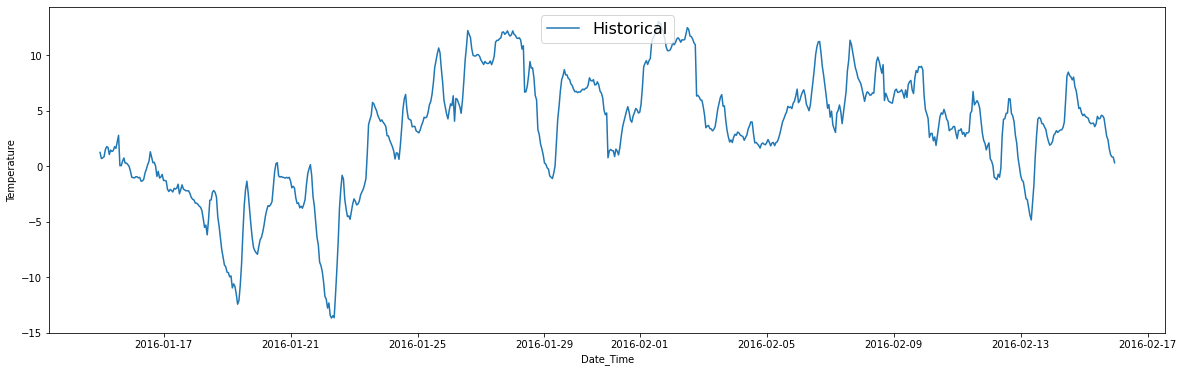

In [4]:
plot_historical_and_forecast(df, 'Date_Time', 'Temperature');

In [14]:
%%bigquery
CREATE OR REPLACE MODEL `pytorch-tpu-nfs.view_dataset.temperature-model`
OPTIONS(model_type='ARIMA_PLUS',
        time_series_data_col='T__degC',
        time_series_timestamp_col='Date_Time'
        )
AS
SELECT DISTINCT 
        CAST(PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time) as TIMESTAMP) as Date_Time,
        T__degC 
FROM `pytorch-tpu-nfs.view_dataset.weather_time_series`
WHERE EXTRACT(date from PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time)) BETWEEN '2012-01-15' AND '2016-02-15'
ORDER BY Date_Time ASC 

""


In [9]:
%%bigquery fcst
SELECT * FROM ML.FORECAST(MODEL `pytorch-tpu-nfs.view_dataset.temperature-model`, 
                  STRUCT(200 AS horizon, 0.9 AS confidence_level))

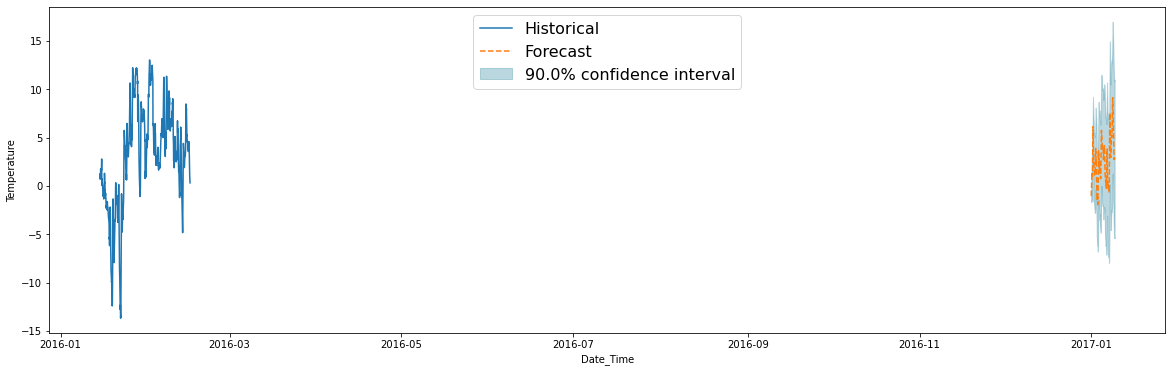

In [10]:
plot_historical_and_forecast(df, 'Date_Time', 'Temperature', fcst);

In [11]:
%%bigquery actual
SELECT
   CAST(PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time) as TIMESTAMP) as Date_Time,
   T__degC as Temperature
FROM
  `pytorch-tpu-nfs.view_dataset.weather_time_series`
WHERE EXTRACT(date from PARSE_DATETIME('%d.%m.%Y  %H:%M:%S', Date_time)) BETWEEN '2016-02-15' AND '2016-02-16'

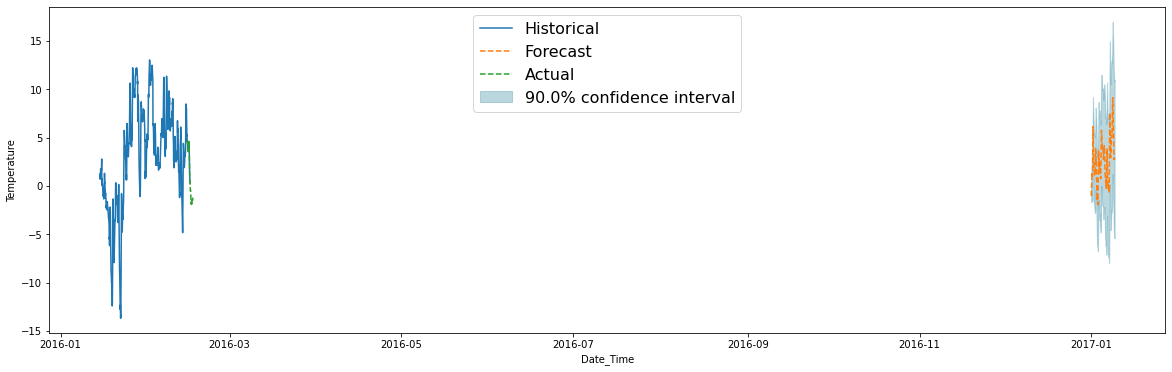

In [12]:
plot_historical_and_forecast(df, 'Date_Time', 'Temperature', fcst, actual);